In [1]:
import numpy as np
from astropy import cosmology
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
import astropy.constants as const
def LoadSources(catalog_dir,
                catalog_file="ULIRG_selection.txt",
                redshift_max=1,#0.13,
                sinDec_min=-1.):
    '''
    Description
    -----------
    Function that reads out the catalog file of selected ULIRGs
    and loads in the information.
    
    
    Arguments
    ---------
    `catalog_dir`
    type        : str
    description : Directory of the catalog file.
    
    `catalog_file`
    type        : str
    description : Option to provide the name of the catalog file.
    
    `redshift_max`
    type        : float
    description : Option to specify the maximum redshift of the
                  sources that are loaded.
    
    `sinDec_min`
    type        : float
    description : Option to specfify the minimum declination of the
                  sources that are loaded.
                  
    Returns
    -------
    `ULIRGs`
    type        : dict
    description : Dictionary containing all the fields that are in the
                  catalog file. In particular it contains the fields
                  relevant for the ULIRG stacking analysis.
    '''
    
    print("\nLoading ULIRGs with z <= {} and sinDec >= {}".format(redshift_max,sinDec_min))

    # Open catalog file
    catalog = open(catalog_dir+catalog_file,"r")
    lines = catalog.readlines()

    # Lists of relevant ULIRG parameters
    # Easier to work with in first instance to load the ULIRG data
    name = []
    ra = []
    dec = []
    redshift = []
    f60 = []
    unc_f60 = []
    lum_IR = []
    catalog_info = []

    # Read out the catalog file
    # Assumes the structure of ULIRG_selection.txt
    start_readout = False
    for line in lines:
        # Skip first lines that do not contain data
        if start_readout == False and line[0][0] == "1":
            start_readout = True

        if start_readout == False:
            continue

        # Columns in the file are split with tabs
        columns = [column for column in line.split("\t") if column != ""]

        # Only load sources with a sinDec larger than `sinDec_min`
        # and with redshift smaller than `redshift_max`
        new_dec      = np.deg2rad( float(columns[3]) )
        new_redshift = float(columns[4])
        
        if np.sin( new_dec ) >= sinDec_min and new_redshift <= redshift_max:
            name.append(columns[1])
            ra.append( np.deg2rad( float(columns[2]) ) )
            dec.append( new_dec )
            redshift.append(float(columns[4]))
            f60.append(float(columns[5]))
            unc_f60.append(float(columns[6]))
            lum_IR.append(float(columns[7]))
            catalog_info.append(columns[8].split(" & "))

    catalog.close()

    # Convert the lists into arrays
    ra = np.array(ra) # [rad]
    dec = np.array(dec) # [rad]
    sinDec = np.sin(dec)
    redshift = np.array(redshift)
    f60 = np.array(f60) # [Jy]
    unc_f60 = np.array(unc_f60) # [Jy]
    lum_IR = np.array(lum_IR) # # [log10(L_sun)]

    # Calculate the luminosity distances
    # from the redshifts using astropy
    # Take the Planck 15 cosmology (H_0 = 67.7 km Mpc^-1 s^-1)
    # built in the astropy package
    distance = np.array(cosmology.Planck15.luminosity_distance(redshift)) # [Mpc]

    # Store all ULIRG parameters in one dictionary
    ULIRGs = {"name"       : name,
              "ra"         : ra,
              "dec"        : dec,
              "sinDec"     : sinDec,
              "redshift"   : redshift,
              "distance"   : distance,
              "f60"        : f60,
              "unc_f60"    : unc_f60,
              "log_lum_IR" : lum_IR,
              "catalog"    : catalog_info}

    # Return ULIRG dictionary
    print( "\nLOADED: {} ULIRGs".format(len(ra)) )
    return ULIRGs

In [2]:
ULIRGs = LoadSources('./')


Loading ULIRGs with z <= 1 and sinDec >= -1.0

LOADED: 189 ULIRGs


In [3]:
import pandas as pd
import astropy.units as u

data = pd.DataFrame(ULIRGs)
def QIR(DL_compl):
    df = pd.DataFrame(data = ULIRGs)
    volume_limited = df[(df['distance'].values <= DL_compl)] 
    logLIR_complete_array = volume_limited['log_lum_IR'].to_numpy()
    LIR_array = pow(10,volume_limited['log_lum_IR']).values
    totalIR = (sum(LIR_array*u.solLum)).to(u.erg/u.yr)      
    Dmax = DL_compl*u.Mpc 
    Volume = (4/3)*pow(Dmax,3)*np.pi 
    return [(totalIR/Volume).value,totalIR.value]

In [4]:
diff = [QIR(d)[0] for d in data.sort_values(by = 'distance')['distance'].values]

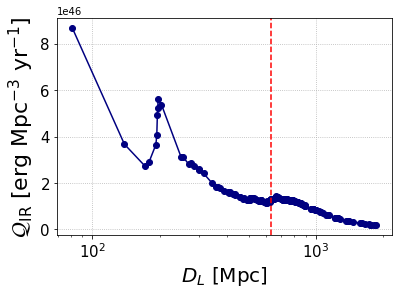

In [5]:
plt.plot(data.sort_values(by = 'distance')['distance'].values,diff,'o-',c='navy')
plt.axvline(x = 630,c='red',ls='dashed')
plt.ylabel('$\\mathcal{Q}_{\\mathrm{IR}}$ [erg Mpc$^{-3}$ yr$^{-1}$]', fontsize = 22)
plt.xlabel('$D_L$ [Mpc]',fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(ls ='dotted')
plt.xscale('log')

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

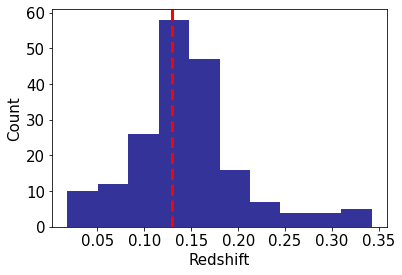

In [6]:
plt.hist(data['redshift'],color='navy',alpha = 0.8)
plt.axvline(x=0.13,color = 'red',ls ='dashed',lw = 3)
plt.xlabel('Redshift',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In [7]:
QIR= QIR(630)[0]

In [8]:
def nu_flux(E,eta_tot,alpha=2,QIR=QIR,fpp=1 ,Emin=1e2, Emax=1e8):
    #alpha = 2.
    if alpha == 2:
        Rp = np.log(Emax/Emin)
    else:
        Rp = ((pow(Emin,-alpha+2)-pow(Emax,-alpha+2))/(alpha-2))*pow(E,alpha-2)    
    diff = (QIR*eta_tot)/Rp
    
    xiz = 3.4
    
    tH = (pow(cosmo.H(0),-1)).to((u.Mpc*u.s)/u.Mpc) #inverse of Hubble parameter in seconds
    ctH = (const.c).to(u.cm/u.s)*tH # unit: cm
    Generation_rate_nunits = (diff*(u.erg/(pow(u.Mpc,3)*u.yr))).to(u.GeV/(pow(u.cm,3)*u.s)) #unit: GeV/(cm3 s)
    Kpi = 0.5
    nu_flux = ((1/3)*((ctH*xiz)/(4*np.pi))*Kpi*fpp*Generation_rate_nunits).value*1e-3# unit: TeV/(cm2 s sr)
    return nu_flux

#nu_flux = np.vectorize(nu_flux)

In [9]:
Erange = np.arange(10,1e4,1)
ul_gamma2 = np.ones(len(Erange))*4e-12
ulirg_predic = [nu_flux(E,0.0018) for E in Erange]

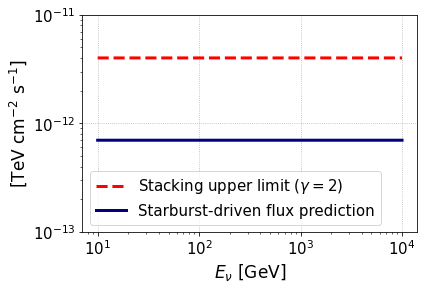

In [10]:

plt.plot(Erange,ul_gamma2, c= 'red',ls = '--',lw = 3, label = 'Stacking upper limit ($\gamma=2$)')
plt.plot(Erange,ulirg_predic,c = 'navy',lw= 3 , label = 'Starburst-driven flux prediction')

plt.ylim(1e-13,1e-11)

plt.grid(ls = 'dotted')
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.ylabel('[TeV cm$^{-2}$ s$^{-1}$]', fontsize = 17 )
plt.xlabel('$E_\\nu$ [GeV]',fontsize = 17)
plt.yscale('log')
plt.xscale('log')

In [11]:
from scipy.optimize import curve_fit
eta_tot_fit = []
for f in np.arange(0.01,1,0.01):
    popt, pcov = curve_fit(lambda E,eta_tot: nu_flux(E,eta_tot,alpha=2,QIR=QIR,fpp=f ,Emin=1e2, Emax=1e8)
                           ,Erange,ul_gamma2)
    eta_tot_fit += [popt[0]]
    


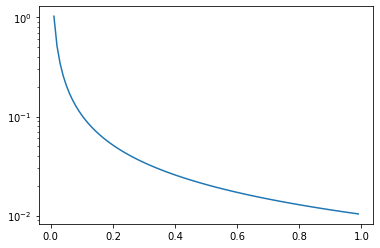

In [12]:
plt.plot(np.arange(0.01,1,0.01), eta_tot_fit)

plt.yscale('log')

In [13]:
nu_flux(1,0.0018*5,alpha=2,QIR=QIR,fpp=1. ,Emin=1e2, Emax=1e8)

3.4995333016979114e-12